# The salinity bias of the high and low models

1. SSS (x, y)
2. section (x/y, z)

In [1]:
import sys
import dask
import numpy as np
import xarray as xr
import cmocean
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
%matplotlib inline
matplotlib.rc_file('rc_file_paper')
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm import tqdm_notebook
from maps import add_cyclic_POP
from paths import path_prace, path_results, file_ex_ocn_ctrl, file_ex_ocn_lpd
from paths import file_RMASK_ocn, file_RMASK_ocn_low, file_RMASK_ocn, file_RMASK_ocn_low
from FW_plots import nlat_at, lat_bounds
from FW_budget import load_obj, lat_bands

### load data

In [4]:
# %%time
# # low: 8 sec; high: 30 s
# for y in tqdm_notebook(np.arange(30)):
#     da = xr.open_dataset(f'{path_prace}/ctrl/ocn_yrly_SALT_VNS_UES_0{y+200:03d}.nc').SALT.drop('time').squeeze()
#     if y==0:  SALT_mean_high = da
#     else: SALT_mean_high += da
# SALT_mean_high /= 30
# SALT_mean_high.drop('time').to_netcdf(f'{path_prace}/ctrl/SALT_mean_ctrl_200-229.nc')

# dsl = []
# for y in tqdm_notebook(np.arange(30)):
#     dsl.append(xr.open_dataset(f'{path_prace}/lpd/ocn_yrly_SALT_VNS_UES_0{y+500:03d}.nc').SALT)
# SALT_mean_lpd  = xr.concat(dsl, dim='time').mean(dim='time')
# SALT_mean_lpd.to_netcdf(f'{path_prace}/lpd/SALT_mean_lpd_500-529.nc')

SALT_mean_orig = xr.open_dataset(f'{path_prace}/EN4/EN4_mean.nc').salinity
SALT_mean_ctrl = xr.open_dataarray(f'{path_prace}/ctrl/SALT_mean_ctrl_200-229.nc')
SALT_mean_high = xr.open_dataarray(f'{path_prace}/EN4/EN4_mean_salinity_high.nc')
SALT_mean_lpd  = xr.open_dataarray(f'{path_prace}/lpd/SALT_mean_lpd_500-529.nc')
SALT_mean_low  = xr.open_dataarray(f'{path_prace}/EN4/EN4_mean_salinity_low.nc')

In [5]:
dz_high = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False).dz
dz_low  = xr.open_dataset(file_ex_ocn_lpd , decode_times=False).dz

In [6]:
SALT_mean_ctrl_top100m = (SALT_mean_ctrl*dz_high).isel(z_t=slice(0,9)).sum('z_t')/dz_high.isel(z_t=slice(0,9)).sum('z_t')
SALT_mean_high_top100m = (SALT_mean_high*dz_high).isel(z_t=slice(0,9)).sum('z_t')/dz_high.isel(z_t=slice(0,9)).sum('z_t')
SALT_mean_lpd_top100m  = (SALT_mean_lpd *dz_low).isel(z_t=slice(0,10)).sum('z_t')/dz_low.isel(z_t=slice(0,10)).sum('z_t')
SALT_mean_low_top100m  = (SALT_mean_low *dz_low).isel(z_t=slice(0,10)).sum('z_t')/dz_low.isel(z_t=slice(0,10)).sum('z_t')

In [7]:
dsh = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False)
dsl = xr.open_dataset(file_ex_ocn_lpd, decode_times=False)
RMASK_ocn = xr.open_dataarray(file_RMASK_ocn)
RMASK_low = xr.open_dataarray(file_RMASK_ocn_low)
Atl_MASK_ocn = xr.DataArray(np.in1d(RMASK_ocn, [6,8,9]).reshape(RMASK_ocn.shape),
                            dims=RMASK_ocn.dims, coords=RMASK_ocn.coords)
Atl_MASK_low = xr.DataArray(np.in1d(RMASK_low, [6,8,9]).reshape(RMASK_low.shape),
                            dims=RMASK_low.dims, coords=RMASK_low.coords)

In [8]:
%%time
# 25 sec
X1, Y1 = np.meshgrid(dsh.TLAT.isel(nlon=800).isel(nlat=slice(811,2000)), -dsh.z_t/1e5)
X2, Y2 = np.meshgrid(dsl.TLAT.isel(nlon=10).isel(nlat=slice(85,380)), -dsl.z_t/1e5)

SALT_Atl_dx      = SALT_mean_high.where(Atl_MASK_ocn).isel(nlat=slice(811,2000)).mean(dim='nlon')
SALT_Atl_ctrl_dx = (SALT_mean_ctrl-SALT_mean_high).where(Atl_MASK_ocn).isel(nlat=slice(811,2000)).mean(dim='nlon')
SALT_Atl_lpd_dx  = (SALT_mean_lpd-SALT_mean_low).where(Atl_MASK_low).isel(nlat=slice(85,380)).mean(dim='nlon')

CPU times: user 4.73 s, sys: 17.1 s, total: 21.9 s
Wall time: 28.1 s


In [9]:
SALT_34S_high = SALT_mean_high.where(Atl_MASK_ocn).isel(nlat=811)
SALT_34S_low  = SALT_mean_low.where(Atl_MASK_low).isel(nlat=85)
SALT_34S_ctrl = SALT_mean_ctrl.where(Atl_MASK_ocn).isel(nlat=811)
SALT_34S_lpd  = SALT_mean_lpd.where(Atl_MASK_low).isel(nlat=85)

In [10]:
def add_cyclic_z_lat(da):
    """ add a cyclis point to a 2D POP output field to remove missing data line in cartopy """
    assert 'z_t' in da.coords
    assert 'TLONG' in da.coords
    lons = np.zeros((len(da.nlon)+1))
    data = np.zeros((len(da.z_t),len(da.nlon)+1))
    lons[:-1] = da.TLONG
    data[:,:-1] = da.data
    lons[-1]  = da.TLONG[0]
    data[:,-1]  = da.data[:,0]
    dims = ['z_t','nlon']
    new_da = xr.DataArray(data=data, dims=dims, coords={'z_t':da.z_t, 'TLONG':(dims,lons)})
    return new_da

In [11]:
from grid import shift_ocn_low

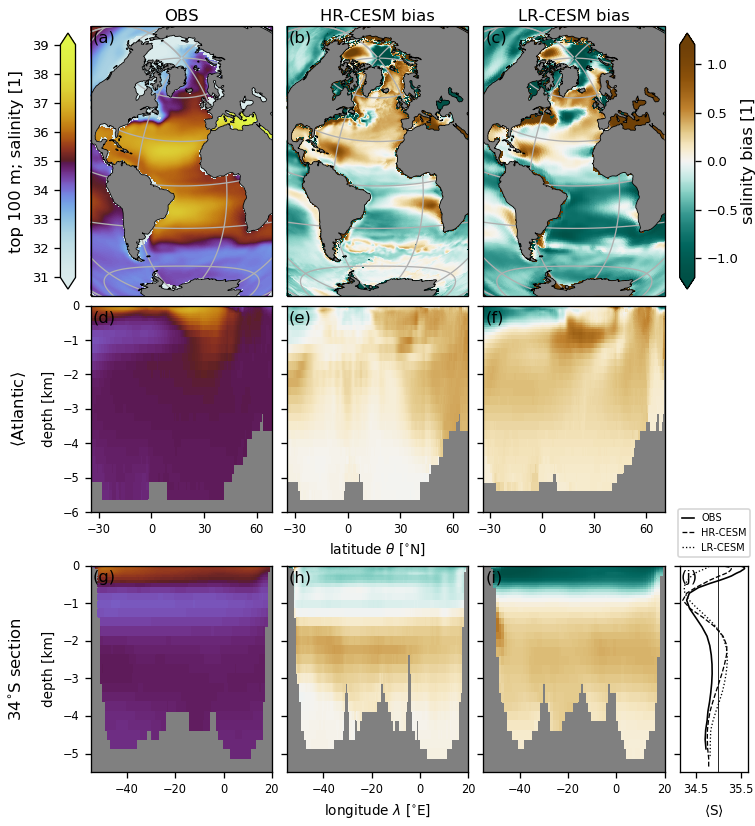

In [12]:
langle, rangle, deg = r'$\langle$', r'$\rangle$', r'$^{\!\circ}\!$'
y1 = np.tanh((np.linspace(0,1, 64)-.5)*4)/2+.5 # nonlinear sampling to enhance center of colormap
y2 = np.tanh((np.linspace(0,1, 64)-.5)*3)/2+.5 # nonlinear sampling to enhance center of colormap

colors1 = cmocean.tools.crop_by_percent(cmocean.cm.dense, 10, which='max', N=None)(np.linspace(0., 1, 128))
colors2 = cmocean.tools.crop_by_percent(cmocean.cm.solar, 10, which='min', N=None)(np.linspace(0, 1, 128))
colors = np.vstack((colors1, colors2))
mymap  = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colors)(y1)
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', mymap)
# mycmap.set_bad('grey',1.)

f = plt.figure(figsize=(6.4,7))
for i in range(3):
    f.text(.24+i*(.26), .975, ['OBS', 'HR-CESM bias', 'LR-CESM bias'][i], ha='center')
    
    # map
    axt = f.add_axes([.12+i*(.72/3+0.02),.64,.72/3,.33], projection=ccrs.LambertAzimuthalEqualArea(central_longitude=-30, central_latitude=20))
    axt.set_extent((-6e6, 3.5e6, -8.5e6, 1e7), crs=ccrs.LambertAzimuthalEqualArea())
    axt.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black', facecolor='grey', linewidth=.5)
    axt.text(.01,.94, '('+['a','b','c'][i]+')', transform=axt.transAxes, color='k')
    
    if i==0:
        xa = SALT_mean_high_top100m.where(RMASK_ocn>0)
        minv, maxv = 31, 39
        cmap = mycmap
    else:
        if i==1:  
            xa = (SALT_mean_ctrl_top100m-SALT_mean_high_top100m).where(RMASK_ocn>0)
        if i==2:
            xa = add_cyclic_POP((SALT_mean_lpd_top100m-SALT_mean_low_top100m).where(RMASK_low>0))
        cmap =  mcolors.LinearSegmentedColormap.from_list('my_BrBG', plt.get_cmap('BrBG_r')(y2))
        minv, maxv = -1.2, 1.2

    # map of top 100m
    im1 = axt.pcolormesh(xa.TLONG, xa.TLAT, xa, cmap=cmap,
                        vmin=minv, vmax=maxv, transform=ccrs.PlateCarree())
    gl = axt.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
    gl.ylocator = matplotlib.ticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    
    # zonal average
    Y1, Z1 = np.meshgrid(dsh.TLAT.isel(nlon=800).isel(nlat=slice(811,2000)), -dsh.z_t/1e5)
    Y2, Z2 = np.meshgrid(dsl.TLAT.isel(nlon=10) .isel(nlat=slice( 85, 380)), -dsl.z_t/1e5)
    axm = f.add_axes([.12+i*(.72/3+0.02),.38,.72/3,.25])
    axm.set_facecolor('grey')
    axm.set_xticks((-30,0,30,60))
    axm.text(.01,.92, '('+['d','e','f'][i]+')', transform=axm.transAxes, color='k')
    im2 = axm.pcolormesh([Y1,Y1,Y2][i], [Z1,Z1,Z2][i],\
                         [SALT_Atl_dx, SALT_Atl_ctrl_dx, SALT_Atl_lpd_dx][i],\
                         cmap=cmap, vmin=minv, vmax=maxv)
    
    # 34S section
    X, Z = np.meshgrid((xa.TLONG-360*(xa.TLONG//180)).isel(nlat=[811,811,85][i]), -[dsh, dsh, dsl][i].z_t/1e5)
    axb = f.add_axes([.12+i*(.72/3+0.02),.065,.72/3,.25])
    axb.set_facecolor('grey')
    axb.text(.01,.92, '('+['g','h','i'][i]+')', transform=axb.transAxes, color='k')
    axb.set_xlim((-55,20))
    data = [SALT_34S_high, SALT_34S_ctrl-SALT_34S_high, SALT_34S_lpd-SALT_34S_low][i]
    axb.pcolormesh(X, Z, data, cmap=cmap, vmin=minv, vmax=maxv)
    
    # legends, labels, ..
    if i==0:
        axt.text(-.45,.5, 'top 100 m; salinity [1]',   va='center', rotation=90, transform=axt.transAxes)
        axm.text(-.45,.5, f'{langle}Atlantic{rangle}', va='center', rotation=90, transform=axm.transAxes)
        axb.text(-.45,.5, f'34{deg}S section',         va='center', rotation=90, transform=axb.transAxes)
        axm.set_ylabel(f'depth [km]')
        axb.set_ylabel(f'depth [km]')
        axl = f.add_axes([.08,.65,.02,.31])
        cbar = plt.colorbar(im1, cax=axl, shrink=.9, orientation='vertical',\
                            extend='both')
        cbar.ax.tick_params(labelsize=8)
        axl.yaxis.set_ticks_position('left')
    else:
        for ax in [axm, axb]:
            ax.set_yticklabels([])
    if i==1:
        axm.set_xlabel(r'latitude $\theta$ [$\!^\circ\!$N]')
        axb.set_xlabel(r'longitude $\lambda$ [$\!^\circ\!$E]')
    axm.set_ylim((-6,0))
    axb.set_ylim((-5.5,0))
    if i==2:  # bias cbar
        axr = f.add_axes([.9,.65,.02,.31])
        cbar = plt.colorbar(im1, cax=axr, shrink=.9, orientation='vertical', extend='both')
        cbar.ax.tick_params(labelsize=8)
        axr.text(8.5,0,'salinity bias [1]', rotation=90, va='center')

# profiles
ax = f.add_axes([.90,.065,.09,.25])
ax.text(.01,.92, '(j)', transform=ax.transAxes, color='k')
ax.set_ylim(-5.5,0)
ax.set_yticklabels([])
ax.set_xticks([34.5,35.5])
ax.set_xlabel(f'{langle}S{rangle}')

s = ax.axvline(35, lw=.5, c='k', label=r'$S_0$')
o, = ax.plot(SALT_34S_high.mean('nlon'), -SALT_34S_high.z_t/1e5, c='k', label='OBS')
h, = ax.plot(SALT_34S_ctrl.mean('nlon'), -SALT_34S_ctrl.z_t/1e5, c='k', ls='--', lw=.8, label='HR-CESM')
l, = ax.plot(SALT_34S_lpd .mean('nlon'), -SALT_34S_lpd .z_t/1e5, c='k', ls=':' , lw=.8, label='LR-CESM')
ax.legend(handles=[o,h,l], fontsize=6, handlelength=1.2, bbox_to_anchor=(-0.1,1.02,1.2,0.2), loc="lower left", mode="expand")
# plt.savefig(f'{path_results}/FW-paper/Fig3', dpi=600)

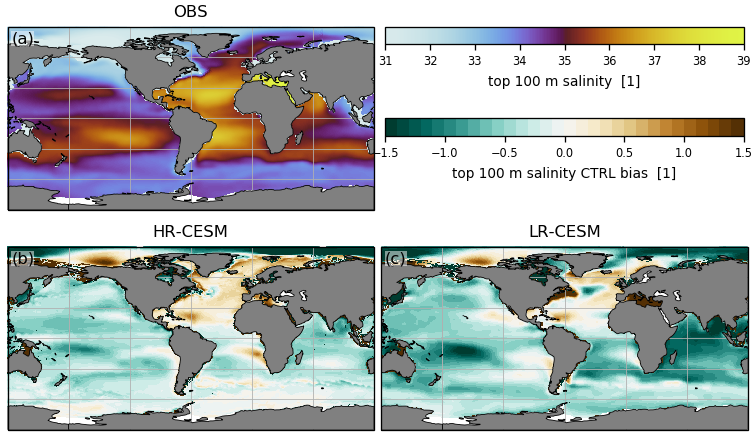

In [13]:
from obs_cesm_maps import bias_maps
from maps import add_cyclic_POP
PmE = minus = r'$P - E$'
kw1 = dict(lat='TLAT', lon='TLONG', label='top 100 m salinity  [1]', cmap=mycmap, vmin=31, vmax=39)
kw2 = dict(label='top 100 m salinity CTRL bias  [1]', cmap=plt.get_cmap('BrBG_r', 30), vmin=-1.5, vmax=1.5)
do = SALT_mean_high_top100m.where(RMASK_ocn>0)
dh = (SALT_mean_ctrl_top100m-SALT_mean_high_top100m).where(RMASK_ocn>0)
dl = add_cyclic_POP((SALT_mean_lpd_top100m-SALT_mean_low_top100m).where(RMASK_low>0))
fn = f'{path_results}/FW-paper/SupplFig3'
# fn = None
bias_maps(do=do, dh=dh, dl=dl, kw1=kw1, kw2=kw2, fn=fn)